In [343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

In [344]:
assess_df = pd.read_csv('assessments.csv', skipinitialspace = True)
assess_df.head()

,id,master_user_id,created_at,user_age,all_devices_count,bank_sms_count,cibil_obligations,cibil_score,matched_devices_count,messages_count,...,sms_unique_days_count,stated_income,suit_filed_count_52,suit_filed_wilful_default_count_52,sum_overdue_amount_52,sum_overdue_amount_cc_52,sum_overdue_amount_non_cc_52,unsecured_inquiry_count_9,wilful_default_count_52,written_off_count_52
0,640,207,2016-10-17 15:02:01.913187+00:00,21.0,0.0,0.0,3441.0,4.0,0.0,0.0,...,0.0,12000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,647,2623,2016-10-17 15:02:01.953184+00:00,32.0,1.0,76.0,0.0,-1.0,1.0,220.0,...,53.0,38000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,649,2937,2016-10-17 15:02:01.961544+00:00,37.0,1.0,45.0,1050.0,715.0,1.0,234.0,...,54.0,22000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,652,1502,2016-10-17 15:02:01.974603+00:00,32.0,1.0,5.0,7910.0,715.0,1.0,30.0,...,8.0,40000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,675,2265,2016-10-17 15:02:02.090573+00:00,50.0,1.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,18000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


In [345]:
loans_df = pd.read_csv('loans.csv', skip_blank_lines = True, skipinitialspace= True)
loans_df.head()

,id,master_user_id,created_at,days_past_due
0,1129,12,2016-06-24 10:24:42.747000+00:00,0
1,46,12,2016-01-27 02:41:18.600000+00:00,0
2,55,27,2016-02-03 05:34:56.029000+00:00,0
3,48,28,2016-01-28 01:32:40.385000+00:00,0
4,50,31,2016-01-28 08:21:04.320000+00:00,0


In [346]:
assess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7353 entries, 0 to 7352
Data columns (total 31 columns):
id                                    7353 non-null int64
master_user_id                        7353 non-null int64
created_at                            7353 non-null object
user_age                              7350 non-null float64
all_devices_count                     7350 non-null float64
bank_sms_count                        7350 non-null float64
cibil_obligations                     6515 non-null float64
cibil_score                           6515 non-null float64
matched_devices_count                 7350 non-null float64
messages_count                        7350 non-null float64
monthly_capacity                      7353 non-null int64
product_type                          7353 non-null object
residence_tenure_in_weeks             6515 non-null float64
restructured_loan_count_52            7350 non-null float64
salary_day_of_month                   1746 non-null float64
s

In [347]:
# deleting rows where cibil_obligations, cibil_score, residence_tenure_in_weeks, and
# sum_overdue_amount_52 are null

#assess_df = assess_df[assess_df['cibil_obligations'].notnull()]

assess_df.dropna(axis = 0, subset = ['cibil_obligations', 'cibil_score','residence_tenure_in_weeks','sum_overdue_amount_52'], inplace = True)
assess_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6515 entries, 0 to 7352
Data columns (total 31 columns):
id                                    6515 non-null int64
master_user_id                        6515 non-null int64
created_at                            6515 non-null object
user_age                              6515 non-null float64
all_devices_count                     6515 non-null float64
bank_sms_count                        6515 non-null float64
cibil_obligations                     6515 non-null float64
cibil_score                           6515 non-null float64
matched_devices_count                 6515 non-null float64
messages_count                        6515 non-null float64
monthly_capacity                      6515 non-null int64
product_type                          6515 non-null object
residence_tenure_in_weeks             6515 non-null float64
restructured_loan_count_52            6515 non-null float64
salary_day_of_month                   1642 non-null float64
s

In [348]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7628 entries, 0 to 7627
Data columns (total 4 columns):
id                7628 non-null int64
master_user_id    7628 non-null int64
created_at        7628 non-null object
days_past_due     7628 non-null int64
dtypes: int64(3), object(1)
memory usage: 238.5+ KB


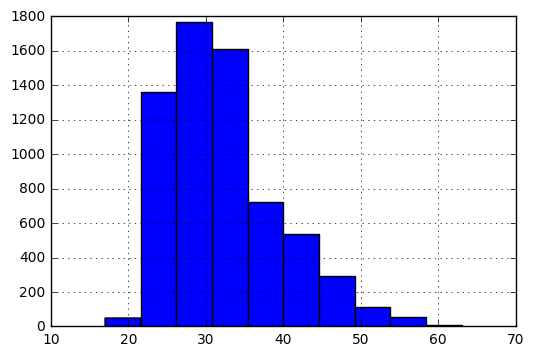

In [349]:
assess_df['user_age'].hist()

In [350]:
assess_df['product_type'].unique()

array(['flexi', 'premium'], dtype=object)

In [351]:
assess_df['scheme'].unique()

array([nan, 'uber', 'ola'], dtype=object)

In [352]:
assess_df.loc[assess_df['product_type'] == 'flexi', 'product_type'] = 0
assess_df.loc[assess_df['product_type'] == 'premium', 'product_type'] = 1
assess_df.head()

,id,master_user_id,created_at,user_age,all_devices_count,bank_sms_count,cibil_obligations,cibil_score,matched_devices_count,messages_count,...,sms_unique_days_count,stated_income,suit_filed_count_52,suit_filed_wilful_default_count_52,sum_overdue_amount_52,sum_overdue_amount_cc_52,sum_overdue_amount_non_cc_52,unsecured_inquiry_count_9,wilful_default_count_52,written_off_count_52
0,640,207,2016-10-17 15:02:01.913187+00:00,21.0,0.0,0.0,3441.0,4.0,0.0,0.0,...,0.0,12000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,647,2623,2016-10-17 15:02:01.953184+00:00,32.0,1.0,76.0,0.0,-1.0,1.0,220.0,...,53.0,38000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,649,2937,2016-10-17 15:02:01.961544+00:00,37.0,1.0,45.0,1050.0,715.0,1.0,234.0,...,54.0,22000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,652,1502,2016-10-17 15:02:01.974603+00:00,32.0,1.0,5.0,7910.0,715.0,1.0,30.0,...,8.0,40000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,675,2265,2016-10-17 15:02:02.090573+00:00,50.0,1.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,18000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


In [353]:
# drop columns with less no. of rows which wont be helpful in prediction

assess_df.drop(['created_at', 'salary_day_of_month', 'salary_estimate','salary_estimate_type','salary_in_payslip', 'scheme'],
              axis = 1 , inplace = True)
assess_df.head()

,id,master_user_id,user_age,all_devices_count,bank_sms_count,cibil_obligations,cibil_score,matched_devices_count,messages_count,monthly_capacity,...,sms_unique_days_count,stated_income,suit_filed_count_52,suit_filed_wilful_default_count_52,sum_overdue_amount_52,sum_overdue_amount_cc_52,sum_overdue_amount_non_cc_52,unsecured_inquiry_count_9,wilful_default_count_52,written_off_count_52
0,640,207,21.0,0.0,0.0,3441.0,4.0,0.0,0.0,3759,...,0.0,12000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,647,2623,32.0,1.0,76.0,0.0,-1.0,1.0,220.0,22800,...,53.0,38000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,649,2937,37.0,1.0,45.0,1050.0,715.0,1.0,234.0,7750,...,54.0,22000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,652,1502,32.0,1.0,5.0,7910.0,715.0,1.0,30.0,16090,...,8.0,40000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,675,2265,50.0,1.0,0.0,0.0,-1.0,0.0,0.0,7200,...,0.0,18000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


In [354]:
assess_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6515 entries, 0 to 7352
Data columns (total 25 columns):
id                                    6515 non-null int64
master_user_id                        6515 non-null int64
user_age                              6515 non-null float64
all_devices_count                     6515 non-null float64
bank_sms_count                        6515 non-null float64
cibil_obligations                     6515 non-null float64
cibil_score                           6515 non-null float64
matched_devices_count                 6515 non-null float64
messages_count                        6515 non-null float64
monthly_capacity                      6515 non-null int64
product_type                          6515 non-null object
residence_tenure_in_weeks             6515 non-null float64
restructured_loan_count_52            6515 non-null float64
secured_inquiry_count_9               6515 non-null float64
sms_days_count                        6515 non-null float64


In [355]:
data_df = pd.merge(assess_df, loans_df, on = 'master_user_id', how = 'inner')
data_df.head(20)

,id_x,master_user_id,user_age,all_devices_count,bank_sms_count,cibil_obligations,cibil_score,matched_devices_count,messages_count,monthly_capacity,...,suit_filed_wilful_default_count_52,sum_overdue_amount_52,sum_overdue_amount_cc_52,sum_overdue_amount_non_cc_52,unsecured_inquiry_count_9,wilful_default_count_52,written_off_count_52,id_y,created_at,days_past_due
0,640,207,21.0,0.0,0.0,3441.0,4.0,0.0,0.0,3759,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,150,2016-02-29 12:01:59.109000+00:00,0
1,640,207,21.0,0.0,0.0,3441.0,4.0,0.0,0.0,3759,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,3370,2016-08-10 04:54:56.464000+00:00,3
2,640,207,21.0,0.0,0.0,3441.0,4.0,0.0,0.0,3759,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,12023,2016-12-11 14:52:55.413000+00:00,0
3,647,2623,32.0,1.0,76.0,0.0,-1.0,1.0,220.0,22800,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1281,2016-07-05 16:56:26.990000+00:00,98
4,649,2937,37.0,1.0,45.0,1050.0,715.0,1.0,234.0,7750,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1412,2016-07-12 08:26:32.454000+00:00,36
5,652,1502,32.0,1.0,5.0,7910.0,715.0,1.0,30.0,16090,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1071,2016-06-21 09:43:18.746000+00:00,36
6,675,2265,50.0,1.0,0.0,0.0,-1.0,0.0,0.0,7200,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1147,2016-06-28 05:25:40.414000+00:00,36
7,676,2120,35.0,1.0,0.0,0.0,-1.0,0.0,0.0,10000,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1409,2016-07-12 07:22:15.539000+00:00,0
8,680,6815,38.0,1.0,0.0,0.0,525.0,0.0,0.0,8000,...,0.0,79359.0,NaN,NaN,0.0,0.0,1.0,2524,2016-07-31 16:13:04.467000+00:00,0
9,684,2540,52.0,1.0,0.0,615.0,2.0,0.0,0.0,7385,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1265,2016-07-05 08:27:15.167000+00:00,159


In [356]:
# drop id_x, id_y and created_at column

data_df.drop(['id_x', 'id_y', 'created_at'], axis = 1, inplace = True)

In [357]:
# function for default column (days_past_due)

def get_default(x):
    return 1 if x > 60 else 0

data_df['default'] = data_df['days_past_due'].apply(get_default)

In [358]:
# drop days_past_due column

data_df.drop(['days_past_due'], axis =1, inplace = True)
data_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7979 entries, 0 to 7978
Data columns (total 25 columns):
master_user_id                        7979 non-null int64
user_age                              7979 non-null float64
all_devices_count                     7979 non-null float64
bank_sms_count                        7979 non-null float64
cibil_obligations                     7979 non-null float64
cibil_score                           7979 non-null float64
matched_devices_count                 7979 non-null float64
messages_count                        7979 non-null float64
monthly_capacity                      7979 non-null int64
product_type                          7979 non-null object
residence_tenure_in_weeks             7979 non-null float64
restructured_loan_count_52            7979 non-null float64
secured_inquiry_count_9               7979 non-null float64
sms_days_count                        7979 non-null float64
sms_unique_days_count                 7979 non-null float6

In [359]:
# checking non null values of sum_overdue_amount_cc_52 & sum_overdue_amount_non_cc_52

# print('unique values for sum_overdue_amount_cc_52 are', data_df['sum_overdue_amount_cc_52'].unique())
# print('unique values for sum_overdue_amount_non_cc_52 are', data_df['sum_overdue_amount_non_cc_52'].unique())

# treating missing values of sum_overdue_amount_cc_52 and sum_overdue_amount_non_cc_52

data_df.loc[data_df['sum_overdue_amount_52'] == 0, 'sum_overdue_amount_cc_52']=0

data_df.loc[data_df['sum_overdue_amount_52'] == 0, 'sum_overdue_amount_non_cc_52']=0

data_df['sum_overdue_amount_non_cc_52'].nunique()

471

In [360]:
data_df.info()
data_df['default'].unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7979 entries, 0 to 7978
Data columns (total 25 columns):
master_user_id                        7979 non-null int64
user_age                              7979 non-null float64
all_devices_count                     7979 non-null float64
bank_sms_count                        7979 non-null float64
cibil_obligations                     7979 non-null float64
cibil_score                           7979 non-null float64
matched_devices_count                 7979 non-null float64
messages_count                        7979 non-null float64
monthly_capacity                      7979 non-null int64
product_type                          7979 non-null object
residence_tenure_in_weeks             7979 non-null float64
restructured_loan_count_52            7979 non-null float64
secured_inquiry_count_9               7979 non-null float64
sms_days_count                        7979 non-null float64
sms_unique_days_count                 7979 non-null float6

array([0, 1])

In [361]:
# dropping rows where sum_overdue_amount_cc_52 and sum_overdue_amount_non_cc_52 are null

data_df.dropna(axis = 0 , subset = ['sum_overdue_amount_cc_52', 'sum_overdue_amount_non_cc_52'], inplace = True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7568 entries, 0 to 7978
Data columns (total 25 columns):
master_user_id                        7568 non-null int64
user_age                              7568 non-null float64
all_devices_count                     7568 non-null float64
bank_sms_count                        7568 non-null float64
cibil_obligations                     7568 non-null float64
cibil_score                           7568 non-null float64
matched_devices_count                 7568 non-null float64
messages_count                        7568 non-null float64
monthly_capacity                      7568 non-null int64
product_type                          7568 non-null object
residence_tenure_in_weeks             7568 non-null float64
restructured_loan_count_52            7568 non-null float64
secured_inquiry_count_9               7568 non-null float64
sms_days_count                        7568 non-null float64
sms_unique_days_count                 7568 non-null float6

In [362]:
data_df.drop(['master_user_id','suit_filed_wilful_default_count_52'], axis =1, inplace = True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7568 entries, 0 to 7978
Data columns (total 23 columns):
user_age                        7568 non-null float64
all_devices_count               7568 non-null float64
bank_sms_count                  7568 non-null float64
cibil_obligations               7568 non-null float64
cibil_score                     7568 non-null float64
matched_devices_count           7568 non-null float64
messages_count                  7568 non-null float64
monthly_capacity                7568 non-null int64
product_type                    7568 non-null object
residence_tenure_in_weeks       7568 non-null float64
restructured_loan_count_52      7568 non-null float64
secured_inquiry_count_9         7568 non-null float64
sms_days_count                  7568 non-null float64
sms_unique_days_count           7568 non-null float64
stated_income                   7568 non-null int64
suit_filed_count_52             7568 non-null float64
sum_overdue_amount_52           75

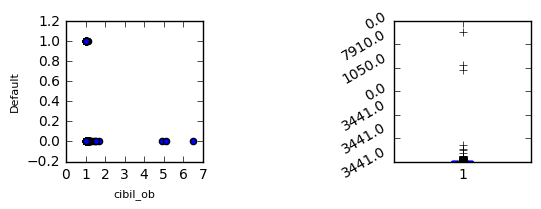

In [363]:
#plot cibil obligations

fig = plt.figure()
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,3)

ax1.scatter(data_df['cibil_obligations'], data_df['default'])
ax1.set_xlabel('cibil_ob', fontsize = 8)
ax1.set_xticklabels(labels = range(0,10000), rotation = 0)
ax1.set_ylabel('Default', fontsize = 8)

ax2.boxplot(data_df['cibil_obligations'], range(0,100000))
ax2.set_yticklabels(data_df['cibil_obligations'], rotation = 30)

plt.show()

In [364]:
data_df.corr()

,user_age,all_devices_count,bank_sms_count,cibil_obligations,cibil_score,matched_devices_count,messages_count,monthly_capacity,residence_tenure_in_weeks,restructured_loan_count_52,...,sms_unique_days_count,stated_income,suit_filed_count_52,sum_overdue_amount_52,sum_overdue_amount_cc_52,sum_overdue_amount_non_cc_52,unsecured_inquiry_count_9,wilful_default_count_52,written_off_count_52,default
user_age,1.000000,-0.185713,-0.139016,0.062293,0.032445,-0.242363,-0.121349,0.014656,0.234117,0.014708,...,-0.186889,0.076201,0.035933,0.077730,0.045014,0.099779,-0.132854,-0.001191,0.084325,-0.009888
all_devices_count,-0.185713,1.000000,0.397900,-0.043706,0.058444,0.914181,0.351383,0.179465,-0.089710,-0.000975,...,0.516704,0.133587,-0.033946,-0.067905,-0.034470,-0.097668,0.147991,-0.011309,-0.044190,0.000713
bank_sms_count,-0.139016,0.397900,1.000000,-0.019961,0.167309,0.458884,0.742720,0.083178,-0.082710,-0.002445,...,0.805742,0.068243,-0.016233,-0.035222,-0.017345,-0.051817,0.113187,-0.005408,-0.019667,-0.080436
cibil_obligations,0.062293,-0.043706,-0.019961,1.000000,0.055944,-0.041388,-0.020763,-0.020342,0.039589,0.003913,...,-0.033020,0.027606,0.005427,0.011992,0.002995,0.023940,-0.001814,-0.001062,0.000613,-0.011054
cibil_score,0.032445,0.058444,0.167309,0.055944,1.000000,0.105676,0.118321,-0.000901,0.141421,0.029692,...,0.155276,0.101525,0.014876,0.025749,0.011585,0.040251,0.110750,0.000985,0.066408,-0.085583
matched_devices_count,-0.242363,0.914181,0.458884,-0.041388,0.105676,1.000000,0.407533,0.122261,-0.113741,-0.000164,...,0.596826,0.080675,-0.030942,-0.062311,-0.031072,-0.090832,0.182897,-0.010309,-0.035243,-0.064340
messages_count,-0.121349,0.351383,0.742720,-0.020763,0.118321,0.407533,1.000000,0.074708,-0.066034,-0.004815,...,0.721830,0.052311,-0.014368,-0.030630,-0.015251,-0.044700,0.090769,-0.004787,-0.007982,-0.066956
monthly_capacity,0.014656,0.179465,0.083178,-0.020342,-0.000901,0.122261,0.074708,1.000000,-0.048995,-0.011425,...,0.090886,0.936275,-0.009449,-0.026746,-0.008374,-0.049725,0.029829,-0.001583,0.002755,0.021943
residence_tenure_in_weeks,0.234117,-0.089710,-0.082710,0.039589,0.141421,-0.113741,-0.066034,-0.048995,1.000000,0.006464,...,-0.081123,-0.029212,0.043414,0.060101,0.022520,0.103728,-0.112736,0.002844,0.058177,0.014256
restructured_loan_count_52,0.014708,-0.000975,-0.002445,0.003913,0.029692,-0.000164,-0.004815,-0.011425,0.006464,1.000000,...,-0.003327,0.000963,-0.001255,0.002268,-0.000585,0.007018,0.013615,-0.000418,0.006035,-0.008627


In [365]:
# creating model

predictor = data_df.columns.tolist()[:21]
print(predictor)

lr = LogisticRegression()
kf = KFold(n_splits = 3, shuffle = True, random_state = 1)
predictions = []
score = []

for train,test in kf.split(data_df):
    train_predictors = data_df[predictor].iloc[train,:]
    train_target = data_df['default'].iloc[train]
    lr.fit(train_predictors,train_target)
    test_predictors = data_df[predictor].iloc[test,:]
    test_target = data_df['default'].iloc[test]
    test_pred = lr.predict(test_predictors)
   
    accuracy = accuracy_score(test_target, test_pred)
    score.append(accuracy)
    
    p, r, f1, support = precision_recall_fscore_support(test_target, test_pred)
    
    auc_roc = roc_auc_score(test_target, test_pred)

#calculating average accuracy , precision, recall, F1 score   
average_score = np.mean(score)
print('Average accuracy is', average_score)

accuracies = cross_val_score(lr, data_df[predictor], data_df['default'],scoring = 'accuracy', cv = 4)    
avg_acc = np.mean(accuracies)
print('average accuracy by cross validation is' , avg_acc)

avg_p = np.mean(p)
print('Average precision is', avg_p)

avg_r = np.mean(r)
print('Average recall is', avg_r)

avg_f1 = np.mean(f1)
print('Average F1 score is', avg_f1)

avg_auc_roc = np.mean(auc_roc)
print('Average AUC - roc score is', avg_auc_roc)

# predictions = np.concatenate(predictions, axis=0)
# accuracy = sum(predictions[predictions == data_df["default"]]) / len(predictions)
# print(predictions)

['user_age', 'all_devices_count', 'bank_sms_count', 'cibil_obligations', 'cibil_score', 'matched_devices_count', 'messages_count', 'monthly_capacity', 'product_type', 'residence_tenure_in_weeks', 'restructured_loan_count_52', 'secured_inquiry_count_9', 'sms_days_count', 'sms_unique_days_count', 'stated_income', 'suit_filed_count_52', 'sum_overdue_amount_52', 'sum_overdue_amount_cc_52', 'sum_overdue_amount_non_cc_52', 'unsecured_inquiry_count_9', 'wilful_default_count_52']


/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average accuracy is 0.94674964422
average accuracy by cross validation is 0.945825075347
Average precision is 0.474028548771
Average recall is 0.5
Average F1 score is 0.486668023611
Average AUC - roc score is 0.5
